In [1]:
import logging
logging.disable(logging.CRITICAL)

import os
import torch
from pathlib import Path
from types import SimpleNamespace
from detectron2.checkpoint import DetectionCheckpointer

import config
import utils as ut
from eval_utils import eval_unsupmf
from mask_former_trainer import setup, Trainer
from typing import Dict, Any
class OurCheckpoint(DetectionCheckpointer):
    def _load_file(self, f: str) -> Dict[str, Any]:
        """
        Load a checkpoint file. Can be overwritten by subclasses to support
        different formats.

        Args:
            f (str): a locally mounted file path.
        Returns:
            dict: with keys "model" and optionally others that are saved by
                the checkpointer dict["model"] must be a dict which maps strings
                to torch.Tensor or numpy arrays.
        """
        return torch.load(f, weights_only=False,map_location=torch.device("cpu"))

torch.cuda.set_device('cuda:0')

def load_model_cfg(ckpt_path, dataset=None):
    experiment = Path('../outputs/') / ckpt_path
    
    # args = SimpleNamespace(config_file=str(experiment / 'config.yaml'), opts=[], wandb_sweep_mode=False, resume_path=str(experiment / 'checkpoints/checkpoint_best.pth'), eval_only=True)  # better way
    args = SimpleNamespace(config_file='configs/maskformer/maskformer_R50_bs16_160k_dino.yaml', opts=["GWM.DATASET", dataset], wandb_sweep_mode=False, resume_path=str(experiment / 'checkpoints/checkpoint_best.pth'), eval_only=True)
    cfg = setup(args)
    random_state = ut.random_state.PytorchRNGState(seed=cfg.SEED).to(torch.device(cfg.MODEL.DEVICE))

    model = Trainer.build_model(cfg)
    checkpointer = OurCheckpoint(model,
                                         random_state=random_state,
                                         save_dir=os.path.join(cfg.OUTPUT_DIR, '../..', 'checkpoints'))
    
    checkpoint_path = str(experiment / 'checkpoints/checkpoint_best.pth')
    checkpoint = checkpointer.resume_or_load(checkpoint_path, resume=False)
    model.eval()
    
    return model, cfg


Using cache found in /home/lzq/.cache/torch/hub/facebookresearch_dino_main


gap
width
height
flow
rgb
torch.Size([3, 128, 224])
original_rgb
category
frame_id
sem_seg
sem_seg_ori
torch.Size([480, 854])
instances
torch.Size([4, 256, 256])
torch.Size([1, 256, 256])
max: tensor(0.8078)
min: tensor(0.0157)
[{'sem_seg': tensor([[[ -8.5565, -11.1125, -12.5973,  ..., -11.8982, -10.6435,  -7.5886],
         [ -7.9230,  -9.3292, -10.1769,  ..., -10.4984,  -9.0578,  -5.1489],
         [ -8.5445,  -9.8129, -10.6988,  ..., -12.5998, -10.2460,  -5.6736],
         ...,
         [-10.7733, -12.6154, -12.9633,  ..., -19.1665, -20.0896, -15.5023],
         [ -9.3696, -11.1599, -11.2705,  ..., -20.2058, -20.1944, -15.2297],
         [ -7.7293,  -8.5629,  -9.0821,  ..., -14.7337, -14.3856, -10.2783]],

        [[ -0.3775,  -1.1563,  -1.0447,  ...,  -1.0231,  -1.1264,  -0.8183],
         [ -1.3419,  -2.9383,  -2.8703,  ...,  -2.6750,  -2.8940,  -2.1399],
         [ -1.3655,  -3.2586,  -3.2434,  ...,  -3.1133,  -3.3536,  -2.2518],
         ...,
         [ -0.4670,  -1.8276,  -2.06

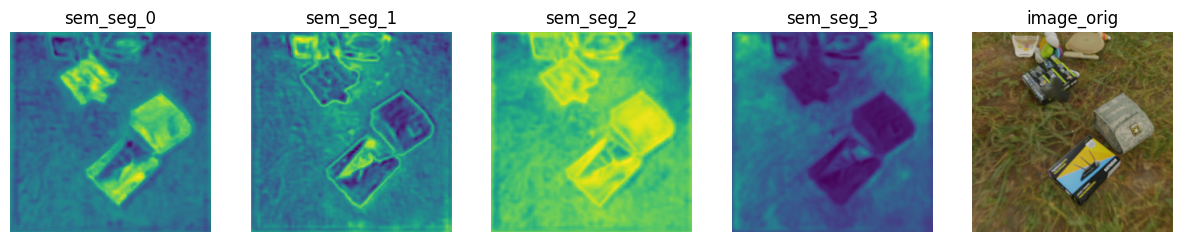

In [4]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt

model, cfg = load_model_cfg('exp/20250209_073351', "DAVIS")
_, val_loader = config.loaders(cfg)
for idx, sample in enumerate(val_loader):
    if idx == 1:
        break
    for k, v in sample[0][0].items():
        print(k)
        if k == 'rgb':
            print(v.shape)
        if k == 'sem_seg_ori':
            print(v.shape)
    #read img from file to torch tensor
    rgb_path = "/home/lzq/workspace/movi-f/outputs/0/rgba_00000.png"
    gt_path = "/home/lzq/workspace/movi-f/outputs/0/segmentation_00000.png"
    image_orig = Image.open(rgb_path)
    gt_mask = Image.open(gt_path)
    image_orig = transforms.ToTensor()(image_orig)
    gt_mask = transforms.ToTensor()(gt_mask)
    print(image_orig.shape)
    print(gt_mask.shape)
    #convert [4, H, W] to [3, H, W]
    image_orig = image_orig[:3]
    print("max:", torch.max(image_orig))
    print("min:", torch.min(image_orig))
    sample = [{'rgb': image_orig*255, 'sem_seg_ori': gt_mask}]
    preds = model.forward_base(sample, keys=['rgb'], get_eval=True)
    print(preds)
    #visualize sem_seg
    fig, ax = plt.subplots(1, 5, figsize=(15, 5))

    for i in range (len(preds[0]["sem_seg"])):
        sem_seg = preds[0]["sem_seg"][i].cpu().detach().numpy()
        ax[i].imshow(sem_seg)
        ax[i].set_title(f'sem_seg_{i}')
        ax[i].axis('off')
    image_orig_np = image_orig.permute(1, 2, 0).cpu().detach().numpy()

    ax[4].imshow(image_orig_np)
    ax[4].set_title('image_orig')
    ax[4].axis('off')

    plt.show()
    # sample = [{'rgb': image_orig[0] * 255, 'sem_seg_ori': gt_mask}]
    # preds = model.forward_base(sample, keys=['rgb'], get_eval=True)

In [7]:

model, cfg = load_model_cfg('exp/20250209_073351', "DAVIS")
_, val_loader = config.loaders(cfg)

            


iou = eval_unsupmf(cfg, val_loader, model, criterion=None)
print(f"DAVIS: {iou:.2f}")

Using cache found in /home/lzq/.cache/torch/hub/facebookresearch_dino_main


gap
width
height
flow
rgb
torch.Size([3, 128, 224])
original_rgb
category
frame_id
sem_seg
sem_seg_ori
torch.Size([480, 854])
instances


Using cache found in /home/lzq/.cache/torch/hub/facebookresearch_dino_main
100%|██████████| 1356/1356 [00:27<00:00, 48.46it/s]

DAVIS: 79.71


In [3]:
model, cfg = load_model_cfg("../checkpoints/STv2", "STv2")
_, val_loader = config.loaders(cfg)
    
iou = eval_unsupmf(cfg, val_loader, model, criterion=None)
print(f"STv2: {iou:.2f}")

Using cache found in /users/subha/.cache/torch/hub/facebookresearch_dino_main
Using cache found in /users/subha/.cache/torch/hub/facebookresearch_dino_main
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1052/1052 [04:36<00:00,  3.80it/s]

STv2: 78.31


In [4]:
model, cfg = load_model_cfg("../checkpoints/FBMS", "FBMS")
_, val_loader = config.loaders(cfg)
    
iou = eval_unsupmf(cfg, val_loader, model, criterion=None)
print(f"FBMS: {iou:.2f}")

Using cache found in /users/subha/.cache/torch/hub/facebookresearch_dino_main
Using cache found in /users/subha/.cache/torch/hub/facebookresearch_dino_main
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 338/338 [01:30<00:00,  3.75it/s]

FBMS: 77.53
